# imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import numpy as np
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
import numpy.ma as ma
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# import R to be used in python 
# sorry R people that may be reading this code 
import rpy2
%load_ext rpy2.ipython

In [3]:
# set white seaborn plotting style 
sns.set(context='talk', style='white', rc={'figure.facecolor':'white'}, font_scale=1)
sns.set_style('ticks')

# read in data

In [4]:
# tissue proportion estimates generated by CelFiE
tissue_proportions = pd.read_csv("celfie_demo/sample_output/1_tissue_proportions.txt", delimiter="\t")

In [5]:
# rename column for nice plotting 
tissue_proportions.rename(columns={"Unnamed: 0": "samples"}, inplace=True)

In [6]:
# change the orientation of the data so that it is easy to plot with seaborn 
tissue_proportions = tissue_proportions.melt("samples",  var_name="tissue", value_name="estimate")

In [7]:
# add a column that groups individuals by pregnancy status
tissue_proportions["status"] = np.where(tissue_proportions["samples"].str.contains("nonpreg"), "not pregnant", "pregnant") 

# plot

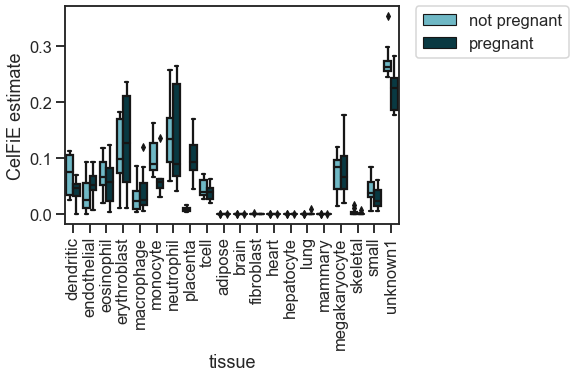

In [8]:
sns.boxplot(x="tissue", y="estimate", hue="status", data=tissue_proportions, palette=["#61c2d3", "#003f4b"])
plt.xticks(rotation=90)
plt.ylabel("CelFiE estimate")
plt.xlabel("tissue")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [9]:
# mean values of placenta 
placenta_estimates = tissue_proportions[tissue_proportions["tissue"] == "placenta"]
placenta_estimates.groupby("status")["estimate"].mean()

status
not pregnant    0.008447
pregnant        0.101466
Name: estimate, dtype: float64

# calculate p-value in R 

In [10]:
# save it to be read by R; can also just do this stand alone in R 
tissue_proportions.to_csv("celfie_demo/sample_output/tissue_proportions.csv", index=False)

In [11]:
%%R 
# R code to calculate the p-value between the estimates of preg/not preg women

df = read.csv("celfie_demo/sample_output/tissue_proportions.csv")  # re-read in the dataframe for this R code 
df$status <- as.character(df$status)
df$status[df$status == "not pregnant"] <- 1
df$status[df$status == "pregnant"] <- 0
df$status <- as.numeric(df$status)

placenta = subset(df, df$tissue=="placenta")

summary(glm(status ~ estimate, data = placenta))



Call:
glm(formula = status ~ estimate, data = placenta)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.58627  -0.14127   0.08918   0.14489   0.41044  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.94964    0.09679   9.811 2.24e-07 ***
estimate    -8.02822    1.29658  -6.192 3.26e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.07271918)

    Null deviance: 3.73333  on 14  degrees of freedom
Residual deviance: 0.94535  on 13  degrees of freedom
AIC: 7.1044

Number of Fisher Scoring iterations: 2



# methylation proportions 

## reference methylation 

In [12]:
reference = pd.read_csv("celfie_demo/sample_data.txt", delimiter="\t").iloc[:, 33:]  # read in reference only 

In [14]:
reference_meth = reference.iloc[:, 3::2].values  # methylation values
reference_depth = reference.iloc[:, 4::2].values  # depth values

In [15]:
reference_prop = reference_meth/reference_depth  # convert to proportion 

## estimated methylation by CelFiE

In [16]:
estimated = pd.read_csv("celfie_demo/sample_output/1_methylation_proportions.txt", delimiter="\t")

In [17]:
estimated_prop = estimated.iloc[:, 1:].values 

In [18]:
# calculate the correlation between the reference data and that estimated by CelFiE

correlation = []

for i in range(reference_prop.shape[1]): 
        corr = ma.corrcoef(ma.masked_invalid(reference_prop[:, i]), 
                          ma.masked_invalid(estimated_prop[:, i]))[0, 1]  # mask Nans
        
        correlation.append(corr)
        
    

# plot correlation 

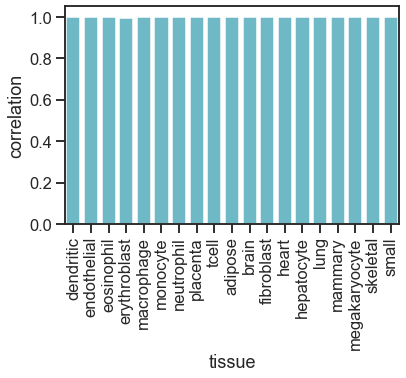

In [19]:
sns.barplot(x=list(estimated)[1:-1], y=correlation, color="#61c2d3")
plt.xticks(rotation=90)
plt.xlabel("tissue")
plt.ylabel("correlation")
plt.show()

# hierarchical clustering 

In [20]:
# append the unknown to the reference data so that they can be clustered together
reference_unknown = np.append(reference_prop, estimated_prop[:, -1].reshape(-1, 1), axis=1)

In [21]:
# drop any missing values 
reference_unknown = pd.DataFrame(reference_unknown)
reference_unknown = reference_unknown.dropna()

In [22]:
reference_unknown_scaled = normalize(reference_unknown)  # normalize data 
reference_unknown_scaled = pd.DataFrame(reference_unknown_scaled, columns=list(estimated)[1:]) # make dataframe again 

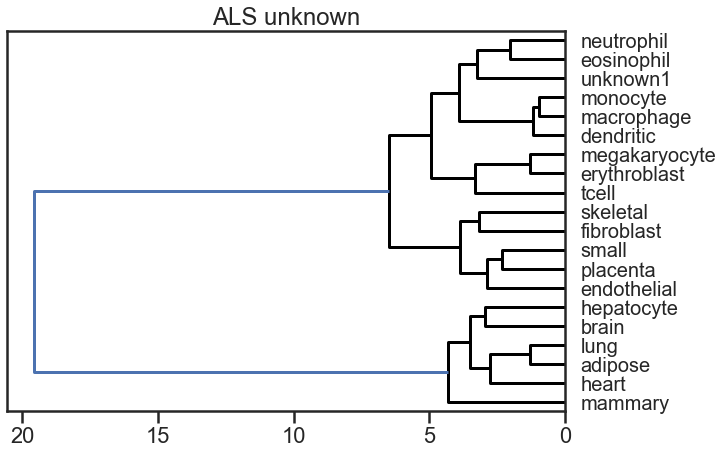

In [23]:
sns.set_context("poster")
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
shc.set_link_color_palette(['black', 'black'])
dend = shc.dendrogram(shc.linkage(reference_unknown_scaled.T, method='ward'), orientation='left', 
                      labels=reference_unknown_scaled.columns, leaf_font_size = 20)
plt.title("ALS unknown")
plt.show()